# Creating, Visualizing and Saving Mol Objects with RDKit in Python

Blurb about the Mol object (rdchem.Mol)

Note about RDKit objects: RDKit syntax can be unusual and it's important to remember that although there is a python API for it, its objects and core functionality are written in C++.  Because of this, returned objects must go through an additional conversion step whenever a python object is wanted as the output of a block of code, and direct copying of variables pointing to RDKit objects will not create a new copy of the object, rather they will create a new variable pointing at the original object.  We'll see several examples of this throughout this lesson.

Goals:
* Create Mol objects from files or dictionaries
* Generate additional Mol objects from existing ones
* Create images and image files from Mol objects
* Polish images, add labels and highlights


## Creating Mol Objects

Mol object instances can be created by a variety of methods.  We've seen some examples of Mol objects being created from SMILES strings and common molecule libraries, now we'll learn some additional ways a Mol can be created.

Data for any system under investigation that is non-ideal, from real systems in experimental methods to optimized geometries in QM methods, cannot be communicated via a smile string.  In these situations, often more detailed specifications are needed, such as an accurate 3D geometry with explicit hydrogens.  Part of the utility of RDKit lies in its ability to create Mol objects using a variety of input formats, so that we can take molecular data from other sources or research processes and generate additional properties and descriptors.

Different methods are called for depending on the format of the molecule's specifications, depending on what you're passing passing around, between researchers, applications, or modules.  Two common and versatile formats that we'll cover today are the MOL file and related Structural Data File (SDF), and building a molecule from a JSON-like python dictionary.

#### Import the modules needed for the lesson

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

### Mol from Mol File

The MOL file is a format first created by MDL internally and published by [Dalby et al. in 1992](https://pubs.acs.org/doi/10.1021/ci00007a012).  It was created specifically for cheminformatics applications and is the most straightforward way of passing detailed structural data and metadata into RDKit.  The formatting is very precise and adhered to strictly by RDKit, so a link to the original paper has been included above.

First, let's take a look at the file

In [2]:
pro_file = 'mol_files/pro.mol'

with open(pro_file) as file:
    print(file.read())

Pro
ref: from 2012-Stover_Dixon_ea

 17 17  0  0  0  0  0  0  0  0999 V2000
    0.6300   -1.0684    0.5217 N 
    0.9344   -1.3645    1.4436 H 
   -0.1181    0.2144    0.6213 C 
   -0.2673    0.4889    1.6696 H 
   -1.5256    0.0697    0.0130 C 
   -2.3126    0.9939   -0.0633 O 
    0.7282    1.2942   -0.1146 C 
    0.3204    1.4724   -1.1134 H 
    0.7133    2.2467    0.4171 H 
    2.1314    0.6640   -0.2043 C 
    2.7164    1.0569   -1.0403 H 
    2.6950    0.8410    0.7188 H 
    1.8131   -0.8337   -0.3476 C 
    1.5473   -1.0680   -1.3847 H 
    2.6331   -1.4941   -0.0554 H 
   -1.7998   -1.1767   -0.4239 O 
   -0.9769   -1.6897   -0.2160 H 
  1  2  1  0
  1  3  1  0
  1 13  1  0
  3  4  1  0
  3  5  1  0
  3  7  1  0
  5  6  2  0
  5 16  1  0
  7  8  1  0
  7  9  1  0
  7 10  1  0
 10 11  1  0
 10 12  1  0
 10 13  1  0
 13 14  1  0
 13 15  1  0
 16 17  1  0
M  END


The first 3 lines in the MOL file are the name followed by any reference information.  The Mol object RDKit creates will store this data under the **private properties** "_Name" and "_MolFileInfo".  All of the built-in private properties can be accessed with the syntax:

    mol = Mol    # create an instance of a Mol Object
    rdk_property_list = mol.GetPropNames(includePrivate=True)    # returns an rdkit object list of tuples
    python_property_list = [prop for prop in rdk_property_list]
    print(python_property_list)

The remaining lines until 'M  END' are the structural data for the molecule, beginning with the counts line followed by the coordinates and then the connectivity.  There can be additional metadata after the connectivity, but that is beyond the scope of this lesson.

Let's make our Mol.  The syntax is:    

    Chem.MolFromMolFile('path/to/file.mol'[, sanitize=True[, removeHs=True[, strictParsing=True]]])

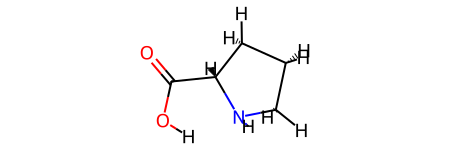

In [3]:
pro = Chem.MolFromMolFile(pro_file, sanitize = False, removeHs=False, strictParsing=False)
pro

Note: Sanitization (see above syntax) deserves a more in-depth discussion and will be covered more below

The image certainly isn't very clean, but it's an optimized geometry, so we wouldn't expect it to be.  We'll learn some ways to clean up images generated from real molecules in the next section.

#### Mol from SDF File

An SDF file is a collection of **MOL file** style string blocks separated by a blank line and a line composed of 4 '$' characters.  It's a very convenient way of passing sets of molecules related in some way such as by similarity or research project between users/machines.  Since each molecule's specifications is already in MOL format, creating Mol objects is very straightforward and a list of Mols is created when the file is read.

The syntax to create a list of Mol objects from an SDF file is:
    
    mol_list = Chem.SDMolSupplier('path/to/file.sdf'[, sanitize=True[, removeHs=True[, strictParsing=True]]])

In [4]:
nat20_sdf = Chem.SDMolSupplier('amino_acids-nat20.sdf', sanitize=False, removeHs=False, strictParsing=False)

for mol in nat20_sdf:
    mol_name = mol.GetProp('_Name')    # conversion to python object, see 'Note about RDKit objects' at top.
    print(mol_name)

Ala
Arg
Asn
Asp
Cys
Gln
Glu
Gly
His
Ile
Leu
Lys
Met
Phe
Pro
Ser
Thr
Trp
Tyr
Val


##### A Note on the SDMolSupplier

nat20 above is not actually a list of mol objects in Python terms, but an **SDMolSupplier** object.  This means that the Mol objects created by it are only temporarily instantiated when called.  This can cause problems when trying to set properties of the Mol objects in the Supplier list, specifically the problem that you can't.

Example:

In [5]:
nat20_sdf[5].SetProp("test", "testing")
print(nat20_sdf[5].GetProp("test"))

KeyError: 'test'

Here, a KeyError is raised because the property set in the first line doesn't exist when the Mol is *re-instantiated* in the second line. 

To get around this, each Mol must be instantiated and assigned to a new variable that is independent of the Supplier.

See the following:

In [ ]:
gln = Chem.Mol(nat20_sdf[5])
gln.SetProp("test", "testing")
print(gln.GetProp("test"))

A list of independent Mol objects can still easily be created in which the Mols have editable properties, by looping through the Supplier, instantiating each Mol and adding it to the list.

In [7]:
nat20 = []
for mol in nat20_sdf:
    mol = Chem.Mol(mol)
    nat20 += [mol]

nat20[5].SetProp("retesting", "1, 2, 3...")
nat20[5].GetProp("retesting")

'1, 2, 3...'

### Building a Mol from a JSON-like dictionary

JSON  (JavaScript Object Notation) and JSON-like files/objects are a common way of passing data sets along with their attributes and parameters/specifications, particularly in the coding community.  MolSSI, for example, uses a JSON-based schema to represent molecules in its QCArchive software.  The syntax is simple, minimal, and nearly identical to a python dictionary.

RDKit has the ability to create Mol objects with either python dictionary or JSON specification, however the sections and data are not automatically interpereted and the **Mol** must be *built* piece by piece using the editable [RWMol class](https://www.rdkit.org/docs/cppapi/classRDKit_1_1RWMol.html).

First, let's define our molecule:

In [ ]:
nm_lys_dict = {    # define the dictionary of molecular specifications
        "N-methyl-Lys": {
        "symbols": [
            'C', 'H', 'H', 'C', 'H', 'H', 'C', 'H', 'H', 'C', 'H', 'H', 'C', 'H', 'C', 'O', 'O', 'H', 'N', 'H', 'H', 'N', 'H', 'C', 'H', 'H', 'H'
        ],
        "geometry": [
            [-2.786344, -0.865688, 0.149704],
            [-3.544874, -1.62842, -0.108673],
            [-2.545274, -1.01452, 1.210478],
            [-1.528672, -1.098787, -0.698099],
            [-1.764375, -0.901138, -1.753684],
            [-1.263847, -2.1625, -0.640239],
            [-0.32661, -0.243046, -0.271657],
            [-0.073497, -0.482642, 0.769845],
            [-0.627382, 0.808673, -0.286552],
            [0.894654, -0.468795, -1.174919],
            [0.645694, -0.193707, -2.205413],
            [1.166248, -1.529929, -1.173636],
            [2.145774, 0.356471, -0.789068],
            [2.943212, 0.078298, -1.48798],
            [2.648295, -0.046693, 0.60451],
            [2.673128, 0.669735, 1.589731],
            [3.093804, -1.337695, 0.635168],
            [3.390314, -1.505546, 1.547838],
            [1.902865, 1.789808, -0.924756],
            [1.251878, 2.096932, -0.205188],
            [2.763947, 2.304041, -0.754109],
            [-3.301475, 0.498923, -0.002148],
            [-3.509828, 0.664275, -0.984668],
            [-4.502157, 0.749743, 0.795616],
            [-4.879941, 1.755202, 0.586094],
            [-5.319415, 0.027338, 0.618035],
            [-4.247693, 0.706975, 1.860456],
        ],
        "connectivity": [
            [0, 1, 1],
            [0, 2, 1],
            [0, 3, 1],
            [0, 21, 1],
            [3, 4, 1],
            [3, 5, 1],
            [3, 6, 1],
            [6, 7, 1],
            [6, 8, 1],
            [6, 9, 1],
            [9, 10, 1],
            [9, 11, 1],
            [9, 12, 1],
            [12, 13, 1],
            [12, 14, 1],
            [12, 18, 1],
            [14, 15, 2],
            [14, 16, 1],
            [16, 17, 1],
            [18, 19, 1],
            [18, 20, 1],
            [21, 22, 1],
            [21, 23, 1],
            [23, 24, 1],
            [23, 25, 1],
            [23, 26, 1],
        ]
    }
}

#### Step 1: Instantiate RWMol object

In [ ]:
base_mol = Chem.Mol()
rw_mol = Chem.RWMol(base_mol)

# we're only working with 1 molecule, so
# we'll set the name of the molecule while making a variable for easy dict access
mol_name = list(nm_lys_dict.keys())[0]
rw_mol.SetProp("_Name", mol_name)

#### Step 2: Add the atoms

In [ ]:
for symbol in nm_lys_dict[mol_name]["symbols"]:
    rw_mol.AddAtom(Chem.Atom(symbol))

Let's verify that worked by printing the list of atom symbols

In [ ]:
atoms = rw_mol.GetAtoms()    # returns a list of Atom objects
msg = "The symbols are: "
for atom in atoms:
    sym_str = f"{atom.GetSymbol()}, "
    msg = msg + sym_str
msg = msg.removesuffix(', ') + '.'
print(msg)

#### Step 3: Add the bonds

Connectivity in RDKit is defined by bond types rather than bond orders.  If one is working with calculated floating point bond orders, additional steps are needed to translate these bond orders into bond types recognizable by RDKit.  Here for simplicity we are using a connectivity list that is already given using RDKit bond type integers.

The bond types can be referenced in the docs under the [BondType class](http://rdkit.org/docs/source/rdkit.Chem.rdchem.html#rdkit.Chem.rdchem.Mol) at the link provided.

First we'll define a dictionary to help translate from a bond type integer to an RDKit object:

In [ ]:
bond_types = {
    0: Chem.BondType.UNSPECIFIED, 
    1: Chem.BondType.SINGLE, 
    2: Chem.BondType.DOUBLE, 
    3: Chem.BondType.TRIPLE, 
    4: Chem.BondType.QUADRUPLE, 
    5: Chem.BondType.QUINTUPLE, 
    6: Chem.BondType.HEXTUPLE, 
    7: Chem.BondType.ONEANDAHALF, 
    8: Chem.BondType.TWOANDAHALF, 
    9: Chem.BondType.THREEANDAHALF, 
    10: Chem.BondType.FOURANDAHALF, 
    11: Chem.BondType.FIVEANDAHALF, 
    12: Chem.BondType.AROMATIC, 
    13: Chem.BondType.IONIC, 
    14: Chem.BondType.HYDROGEN, 
    15: Chem.BondType.THREECENTER, 
    16: Chem.BondType.DATIVEONE, 
    17: Chem.BondType.DATIVE, 
    18: Chem.BondType.DATIVEL, 
    19: Chem.BondType.DATIVER, 
    20: Chem.BondType.OTHER, 
    21: Chem.BondType.ZERO
}

Now we can add the bonds similarly to the atoms.

In [ ]:
for atom1, atom2, bond in nm_lys_dict[mol_name]["connectivity"]:
    bondtype = bond_types[bond]
    rw_mol.AddBond(atom1, atom2, bondtype)

Notice there is only 1 double bond in N-*m*-Lys, between atom indices 14 and 15. We can use this to verify that the process worked:

In [ ]:
carbonyl = rw_mol.GetBondBetweenAtoms(14, 15)    # returns a C++ Bond object
print(carbonyl.GetBondType())    # see 'Note about RDKit objects' at top.

#### Step 4: Get Mol and Set a Conformer

At this point we can obtain a normal **Mol object** that can be used to generate some molecular properties/descriptors, such as a smiles string, bonding information, etc.  But this **Mol** lacks a conformer (geometry), so any properties that require an accurate geometry to calculate will not return accurate results.

Let's see an example of this.  The syntax to get a Mol object from a RWMol object is:
    
    mol = rw_mol.GetMol()

In [ ]:
methyl_lysine_no_geom = rw_mol.GetMol()    # First we get our molecule

Chem.SanitizeMol(methyl_lysine_no_geom)

# A smiles string can be generated from the Mol as is. Explicit Hs are removed at the same time.
m_lys_smiles = Chem.MolToSmiles(Chem.RemoveHs(methyl_lysine_no_geom))
print(m_lys_smiles)

# Let's look at the generated Mols both raw and from SMILES (after removing implicit Hs)
mols = [methyl_lysine_no_geom, Chem.MolFromSmiles(m_lys_smiles)]
Draw.MolsToGridImage(mols,molsPerRow=2,subImgSize=(300,300))

As we can see, there is no geometry or stereochemistry information, and if we ask for the number of conformers, we get 0.

In [ ]:
methyl_lysine_no_geom.GetNumConformers()
Chem.FindMolChiralCenters(methyl_lysine_no_geom)

**4b: Setting the conformer**

In [ ]:
# First we create a conformer object
geom = Chem.Conformer(len(nm_lys_dict[mol_name]["symbols"]))

# Then loop through the geometry lines setting the atom positions
for index, coords in enumerate(nm_lys_dict[mol_name]["geometry"]):
    geom.SetAtomPosition(
        index,
        coords
    )

# Make a new Mol object so the old is saved for comparison.
# Note: Must call Mol constructor class to create new Mol object. see 'Note about RDKit objects' at top.
methyl_lysine = Chem.Mol(methyl_lysine_no_geom)

# Add the conformer to the Mol
methyl_lysine.AddConformer(geom)

Now let's compare the two *N-methyl*-lysine molecules:

In [ ]:
mols = [methyl_lysine, methyl_lysine_no_geom]
Draw.MolsToGridImage(mols,molsPerRow=2,subImgSize=(300,300))